# **Decision tree**

Notes about the model:
- Non-parametric supervised learning method that can be used for classification, like the problem in study
- The goal is to create a model that predicts the value of Attiction by learning decision rules inferred from the data features
- The algorithm supports numeric and categorical variables, scikit-learn implementation does not support categorical variables directly so, as in other models, it will be required to handle those cases by using dummies
- Decision-tree  can create over-complex trees that do not generalize the data well - overfitting. If happens it will be necessary to recur to mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree.
- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.
- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree. 

Support: https://scikit-learn.org/stable/modules/tree.html#


## **1. Import the model and necessary libraries**

In [4]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

In [ ]:
#class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
#                                          min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#                                          max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#                                          class_weight=None, ccp_alpha=0.0, monotonic_cst=None)

## **2. Import data**

In [5]:

from scripts.preprocessing_for_EDA import preprocess_for_eda

# Get the path of this notebook
base_path = Path.cwd()

# Build the path to the dataset relative to the project structure
data_path = base_path / "data" / "raw" / "HR_Attrition_Dataset.csv"

# Load the original file
HR_DT = pd.read_csv(base_path / "data" / "raw" / "HR_Attrition_Dataset.csv")

# Apply the preprocessing function, available in scripts/preprocessing_for_EDA.py
HR_DT = preprocess_for_eda(HR_DT)

In [6]:
HR_DT.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
4,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
5,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
7,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


## **3. Implementing the model - Version 1**

### **3.1. Feature selection**

Resulting from the feature selection study made previously, on the first version 5 features were selected to train the model.

In [15]:
HR_DT_1 = HR_DT[['TotalWorkingYears','MaritalStatus','PercentSalaryHike','YearsAtCompany', 'Attrition']].copy()

In [16]:
HR_DT_1.head()

,TotalWorkingYears,MaritalStatus,PercentSalaryHike,YearsAtCompany,Attrition
EmployeeNumber,,,,,
1,8,Single,11,6,Yes
2,10,Married,23,10,No
4,7,Single,15,0,Yes
5,8,Married,11,8,No
7,6,Married,12,2,No


### **3.2. Appying transformations**

In [17]:
#Encode target variable
HR_DT_1['Attrition'] = HR_DT_1['Attrition'].map({'Yes': 1, 'No': 0})

#Apply one-hot encoding to categorical variables
HR_DT_1 = pd.get_dummies(HR_DT_1, columns=['MaritalStatus'], drop_first=True)

### **3.3. Train, Validation and Test Split**

In [20]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = HR_DT_1.drop('Attrition', axis=1)
y = HR_DT_1['Attrition']

# Check class distribution
print("Class distribution:")
print(y.value_counts())
print(f"\nClass percentages:\n{y.value_counts(normalize=True)*100}")

def train_val_test_split(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42):
    """
    Split data into train, validation, and test sets.
    """
    assert train_size + val_size + test_size == 1.0, "Sizes must sum to 1"
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Second split: separate train and validation
    val_size_adjusted = val_size / (train_size + val_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, 
        random_state=random_state, stratify=y_temp
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Use it in one line!
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42
)

# Verify the splits
print(f"\n{'='*50}")
print("DATASET SPLIT SUMMARY")
print(f"{'='*50}")
print(f"Total samples: {len(HR_DT_1)}")
print(f"\nTRAINING set:   {len(X_train)} samples ({len(X_train)/len(HR_DT_1)*100:.1f}%)")
print(f"VALIDATION set: {len(X_val)} samples ({len(X_val)/len(HR_DT_1)*100:.1f}%)")
print(f"TEST set:       {len(X_test)} samples ({len(X_test)/len(HR_DT_1)*100:.1f}%)")

print(f"\n{'='*50}")
print("CLASS DISTRIBUTION (Attrition)")
print(f"{'='*50}")
print(f"Train:      {y_train.value_counts().sort_index().to_dict()}")
print(f"Validation: {y_val.value_counts().sort_index().to_dict()}")
print(f"Test:       {y_test.value_counts().sort_index().to_dict()}")

print(f"\n{'='*50}")
print("YOUR DATA IS NOW READY!")
print(f"{'='*50}")
print("✓ X_train, y_train  → Use for training the model")
print("✓ X_val, y_val      → Use for tuning hyperparameters")
print("✓ X_test, y_test    → Use ONLY for final evaluation")

Class distribution:
Attrition
0    1233
1     237
Name: count, dtype: int64

Class percentages:
Attrition
0    83.877551
1    16.122449
Name: proportion, dtype: float64

DATASET SPLIT SUMMARY
Total samples: 1470

TRAINING set:   882 samples (60.0%)
VALIDATION set: 294 samples (20.0%)
TEST set:       294 samples (20.0%)

CLASS DISTRIBUTION (Attrition)
Train:      {0: 739, 1: 143}
Validation: {0: 247, 1: 47}
Test:       {0: 247, 1: 47}

YOUR DATA IS NOW READY!
✓ X_train, y_train  → Use for training the model
✓ X_val, y_val      → Use for tuning hyperparameters
✓ X_test, y_test    → Use ONLY for final evaluation


### **3.4. Handling class imbalance**

In this case, the class imbalance will be handled with the parameter class_weight - balanced. The next cell allows the pratic interpretation of the model.


In [ ]:

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print(f"\nComputed class weights: {class_weight_dict}")




Computed class weights: {np.int64(0): np.float64(0.5967523680649527), np.int64(1): np.float64(3.0839160839160837)}


During the training:
- When the model fails to predict that one employee is leaving (1), receives one penalty of 3.08
- When the model fails to predict that one employee isn't leaving (0), received one penalty of 0.60

The model is being penalized almost 5 times more when it doesn't identify correctly the employees that will leave the company.


### **3.5. Train Decision Tree with class weights**

In [ ]:

dt_model = DecisionTreeClassifier(criterion='entropy',
    max_depth=3,
    min_samples_split=20,
    min_samples_leaf=20,
    class_weight='balanced',  # Handles imbalance
    random_state=42
)

dt_model.fit(X_train, y_train)

In [ ]:
#class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
#                                          min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#                                          max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#                                          class_weight=None, ccp_alpha=0.0, monotonic_cst=None)

### **3.6. Evaluate on validation set**

In [ ]:
y_val_pred = dt_model.predict(X_val)
y_val_proba = dt_model.predict_proba(X_val)[:, 1]

print("\n" + "="*50)
print("VALIDATION SET RESULTS")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

if len(np.unique(y_val)) > 1:
    print(f"\nROC-AUC Score: {roc_auc_score(y_val, y_val_proba):.4f}")


VALIDATION SET RESULTS

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.84       247
           1       0.33      0.60      0.43        47

    accuracy                           0.74       294
   macro avg       0.62      0.68      0.63       294
weighted avg       0.82      0.74      0.77       294


Confusion Matrix:
[[191  56]
 [ 19  28]]

ROC-AUC Score: 0.7029


### **3.7. Evaluate on validation set**

In [ ]:

y_test_pred = dt_model.predict(X_test)
y_test_proba = dt_model.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

if len(np.unique(y_test)) > 1:
    print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_test_proba):.4f}")




TEST SET RESULTS

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76       247
           1       0.24      0.55      0.34        47

    accuracy                           0.65       294
   macro avg       0.57      0.61      0.55       294
weighted avg       0.78      0.65      0.70       294


Confusion Matrix:
[[166  81]
 [ 21  26]]

ROC-AUC Score: 0.6066


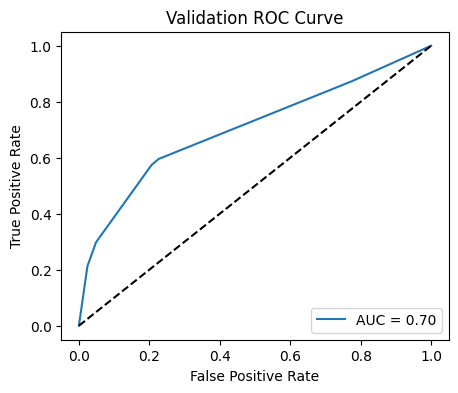

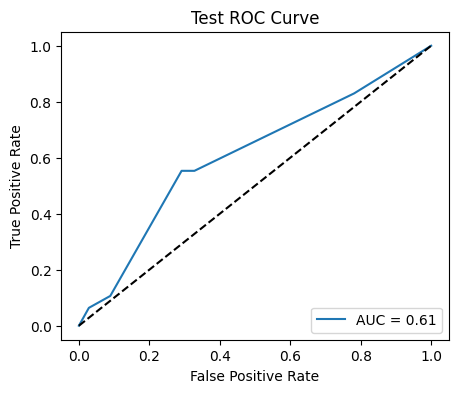

In [39]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_proba, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc(y_val, y_val_proba, 'Validation ROC Curve')
plot_roc(y_test, y_test_proba, 'Test ROC Curve')

The variables: 
- JobSatisfaction 
- JobInvolvement
- EnvironmentSatisfaction
- JobRole
- BusinessTravel
- WorkLifeBalance
- Department
- YearsAtCompany
- TotalWorkingHours
- MaritalStatus
- OverTime  

In [ ]:
# STEP 6: Feature importance
feature_importance = pd.DataFrame({
    'feature': [f'feature_{i}' for i in range(n_features)],
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*50)
print("TOP 5 FEATURE IMPORTANCES")
print("="*50)
print(feature_importance.head())

# Additional tips for handling imbalanced data:
print("\n" + "="*50)
print("ALTERNATIVE APPROACHES FOR IMBALANCED DATA")
print("="*50)
print("""
1. SMOTE (Synthetic Minority Over-sampling Technique):
   from imblearn.over_sampling import SMOTE
   smote = SMOTE(random_state=42)
   X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

2. Random Under-sampling:
   from imblearn.under_sampling import RandomUnderSampler
   rus = RandomUnderSampler(random_state=42)
   X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

3. Adjust decision threshold:
   Instead of 0.5, find optimal threshold using validation set

4. Use ensemble methods:
   - Random Forest with balanced class weights
   - Balanced Bagging Classifier
   - XGBoost with scale_pos_weight parameter
""")